In [1]:
import sys

sys.path.append("./../..")

from numba import jit
import numpy as np
import matplotlib.pyplot as plt
from InternalLibrary.StatisticalFunctions import stat_corr_single
from scipy.optimize import curve_fit

from tqdm import tqdm

from sbi import analysis as analysis
from sbi import utils as utils
from sbi.inference import SNPE, simulate_for_sbi, infer
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)
import torch

C:\Users\loren\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
@jit
def OrnsteinUhlenbeck(param, n_sim, dt = 0.01, TotalT = 1):
    k = param[0]
    D = param[1]
    time_steps_amount = np.int64(TotalT/dt)

    x = np.zeros((1, n_sim))
    x_tilde = np.zeros((1, n_sim))
    x_trace = np.zeros((n_sim, time_steps_amount))
    
    for t in np.arange(0, time_steps_amount):
        
        x_tilde[:]   = x[:] + -k * x[:] * dt + np.sqrt(2*D) * np.random.normal(0, np.sqrt(dt), size = (1,n_sim))
        x[:]         = x_tilde + (+k * x[:] - k*x_tilde[:])*dt /2
        x_trace[:,t] = x[:,]
    
    return x_trace


def GenerateDataForSBI(n_sim, prior_limits, dt = 0.01, TotalT = 1):
    # Generate the parameters
    params = np.array([np.random.uniform(prior_limits["k"][0], prior_limits["k"][1], n_sim), np.random.uniform(prior_limits["D"][0], prior_limits["D"][1], n_sim)])
    # Simulate the data
    trace = OrnsteinUhlenbeck(params, n_sim, dt, TotalT)
    # Save the trace and the parameters in the correct format
    trace = torch.tensor(np.array(trace)).float()
    params = torch.tensor(np.array(params)).float()
    
    return trace, params.T
    

In [3]:
dt = 1e-2 # Time Step in seconds
TotalT = 1000 # Total Time in seconds
param = [2., 3.] # [k, D]
t = np.arange(0, TotalT, dt)
prior_limits = {"k": [0.0,5.0],
                "D": [0.0,5.0]}

In [4]:
# Run the simulation
x_trace = OrnsteinUhlenbeck(param, n_sim = 10, dt = dt, TotalT = TotalT)

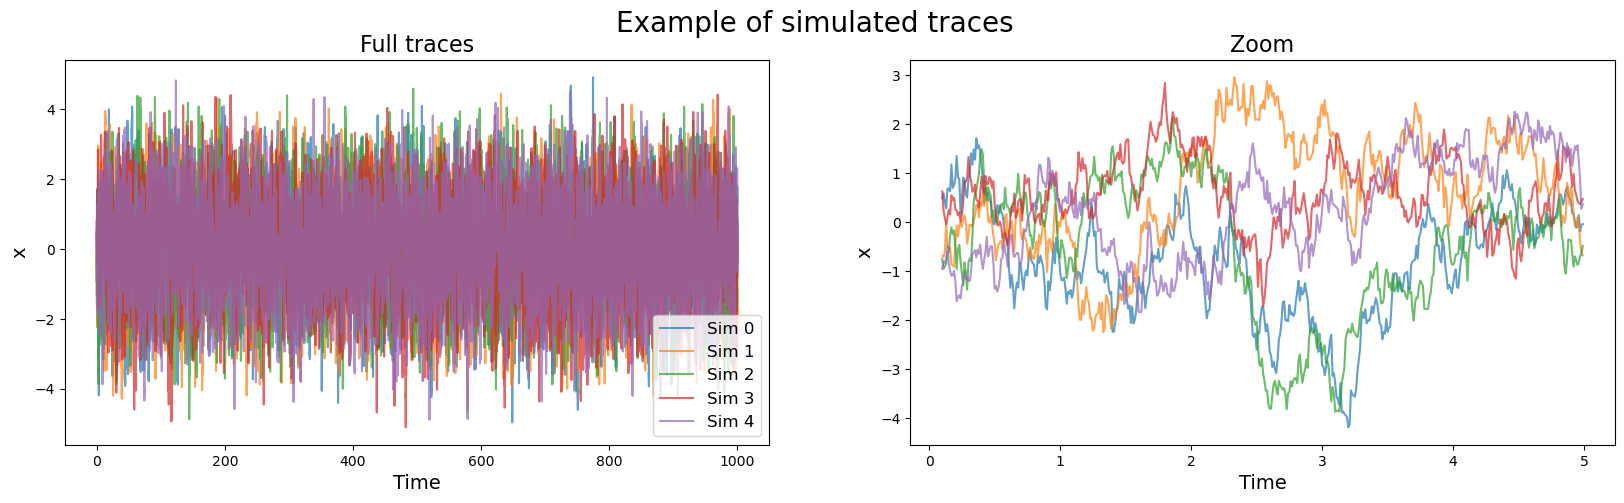

In [9]:
# Example of simulated traces
plt.figure(figsize=(20, 5))
plt.suptitle("Example of simulated traces", fontsize=20)

plt.subplot(121)
for i in range(min([10, 5])):
    plt.plot(t[:], x_trace[i], label=f"Sim {i}", alpha=0.7)
plt.title("Full traces", fontsize=16)
plt.xlabel("Time", fontsize=14)
plt.ylabel("x", fontsize=14)
plt.legend(fontsize=12)

plt.subplot(122)
for i in range(min([10, 5])):
    plt.plot(t[10:500], x_trace[i, 10:500], label=f"Sim {i}", alpha=0.7)
plt.title("Zoom", fontsize=16)
plt.xlabel("Time", fontsize=14)
plt.ylabel("x", fontsize=14);


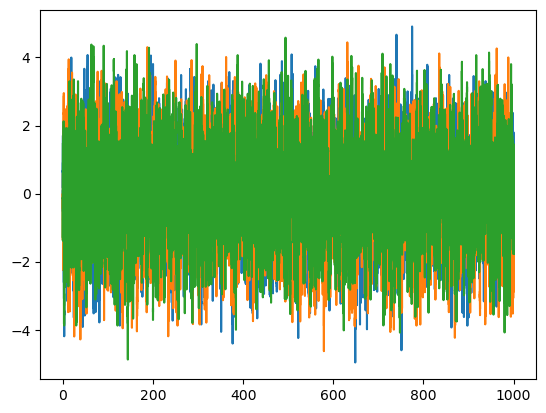

In [5]:
# Plot the trace
fig, ax = plt.subplots()
ax.plot(t[:], x_trace[0,:])
ax.plot(t[:], x_trace[1,:])
ax.plot(t[:], x_trace[2,:]);

In [6]:
# Compute interesting descriptors
mean = np.mean(x_trace)
std = np.std(x_trace)
mean_x_squared = np.mean(x_trace**2)

print(f"Mean: {mean:.2f}")
print(f"Standard Deviation: {std:.2f}")
print(f"Mean of x^2: {mean_x_squared:.2f}")

Mean: -0.02
Standard Deviation: 1.24
Mean of x^2: 1.53


Fitted Autocorrelation Decay Time: 0.46
Fitted Autocorrelation Amplitude: 1.45
True Autocorrelation Decay Time: 0.50
True Autocorrelation Amplitude: 1.50


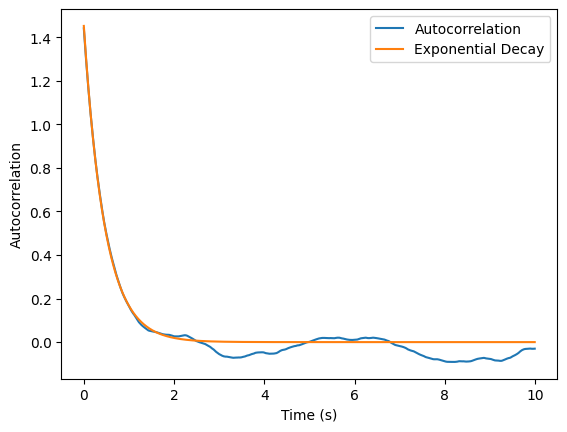

In [7]:
# Autocorrelation
autocorrelation = stat_corr_single(x_trace[0],DeltaT = dt)
## Fit autocorrelation with exponential decay
def exp_decay(t, A, tau):
    return A*np.exp(-t/tau)
popt, pcov = curve_fit(exp_decay, t[:len(autocorrelation)], autocorrelation, p0 = [1, 1])
A, tau = popt
print(f"Fitted Autocorrelation Decay Time: {tau:.2f}")
print(f"Fitted Autocorrelation Amplitude: {A:.2f}")
print(f"True Autocorrelation Decay Time: {1/param[0]:.2f}")
print(f"True Autocorrelation Amplitude: {param[1]/param[0]:.2f}")

## Plot the autocorrelation

fig, ax = plt.subplots()
ax.plot(t[:1000], autocorrelation[:1000], label = "Autocorrelation")
ax.plot(t[:1000], exp_decay(t[:1000], A, tau), label = "Exponential Decay")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Autocorrelation")
ax.legend();


# SBI with the raw trace

In [8]:
# Setup SBI boilerplate
prior_box = utils.BoxUniform(low=torch.tensor([0.0, 0.0]), high=torch.tensor([5.0, 5.0]))
prior, num_parameters, prior_returns_numpy = process_prior(prior_box)
infer = SNPE(prior=prior)

In [9]:
# Generate data in SBI format
n_sim = 14000
trace, params = GenerateDataForSBI(n_sim, prior_limits, dt = dt, TotalT = TotalT)
trace = trace.reshape(n_sim, len(t))

In [10]:
# Train density estimator and extrace the posterior
inference = infer.append_simulations(params, trace)
density_estimator = inference.train()
posterior = inference.build_posterior(density_estimator)

 Neural network successfully converged after 22 epochs.

In [11]:
# Generate test data
n_test = 1
trace_test, params_test = GenerateDataForSBI(n_test, prior_limits, dt = dt, TotalT = TotalT)

python(19099) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

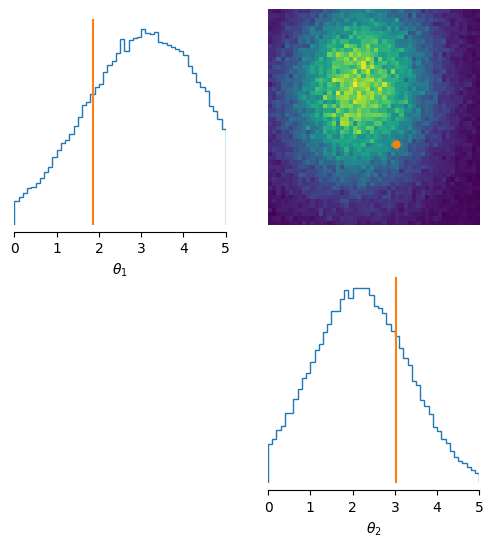

In [12]:
# Use test data to check if the posterior is working
samples = posterior.sample((100000,), x=trace_test.reshape(n_test, len(t)))
_ = analysis.pairplot(samples, points=params_test, limits=[[0.0, 5.], [0, 5.]], figsize=(6, 6), labels=[r"$\theta_1$", r"$\theta_2$"])

# SBI with autocorrelation

In [13]:
# Generate the autocorrelation
autocorrelation = np.zeros_like(trace)

for i in tqdm(np.arange(n_sim)):
    autocorrelation[i,:] = stat_corr_single(np.array(trace[i,:]),DeltaT = dt)
    
autocorrelation = torch.tensor(autocorrelation).float()

100%|██████████| 14000/14000 [03:50<00:00, 60.84it/s]


In [14]:
# Setup SBI boilerplate
prior_box = utils.BoxUniform(low=torch.tensor([0.0, 0.0]), high=torch.tensor([5.0, 5.0]))
prior, num_parameters, prior_returns_numpy = process_prior(prior_box)
infer = SNPE(prior=prior)

In [15]:
# Train density estimator and extrace the posterior
inference = infer.append_simulations(params, autocorrelation[:,:1000])
density_estimator = inference.train()
posterior = inference.build_posterior(density_estimator)

 Neural network successfully converged after 122 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

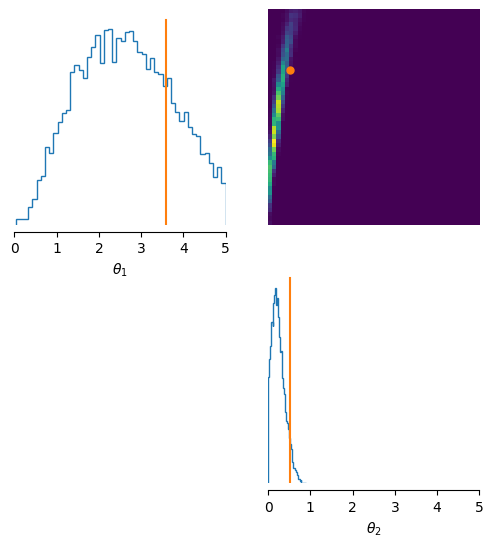

In [16]:
# Generate test data
n_test = 1
trace_test, params_test = GenerateDataForSBI(n_test, prior_limits, dt = dt, TotalT = TotalT)
autocorr_test = stat_corr_single(np.array(trace_test[0,:1000]),DeltaT = dt)
# Use test data to check if the posterior is working
samples = posterior.sample((10000,), x=autocorr_test[:1000])
_ = analysis.pairplot(samples, points=params_test, limits=[[0.0, 5.], [0, 5.]], figsize=(6, 6), labels=[r"$\theta_1$", r"$\theta_2$"])

## Subsampling the autocorrelation

In [17]:
# Sample the autocorrelation to reduce the size with different strategies
lin_autocorr_sample = autocorrelation[:,np.linspace(0, len(autocorrelation)-1, 500, dtype=np.int32)]
log_autocorr_sample = autocorrelation[:,np.logspace(0, np.log10(len(autocorrelation)-1), 20, dtype=np.int32)]

print(f"Linear Autocorrelation Sample Shape: {lin_autocorr_sample.shape}")
print(f"Log Autocorrelation Sample Shape: {log_autocorr_sample.shape}")

Linear Autocorrelation Sample Shape: torch.Size([14000, 500])
Log Autocorrelation Sample Shape: torch.Size([14000, 20])


In [19]:
## Linear Sampling of the Autocorrelation

# Setup SBI boilerplate
# Setup SBI boilerplate
prior_box = utils.BoxUniform(low=torch.tensor([0.0, 0.0]), high=torch.tensor([5.0, 5.0]))
prior, num_parameters, prior_returns_numpy = process_prior(prior_box)
infer = SNPE(prior=prior)
# Train density estimator and extrace the posterior
inference_lin = infer.append_simulations(params, lin_autocorr_sample)
density_estimator_lin = inference_lin.train()
posterior_lin = inference_lin.build_posterior(density_estimator_lin)

 Neural network successfully converged after 100 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

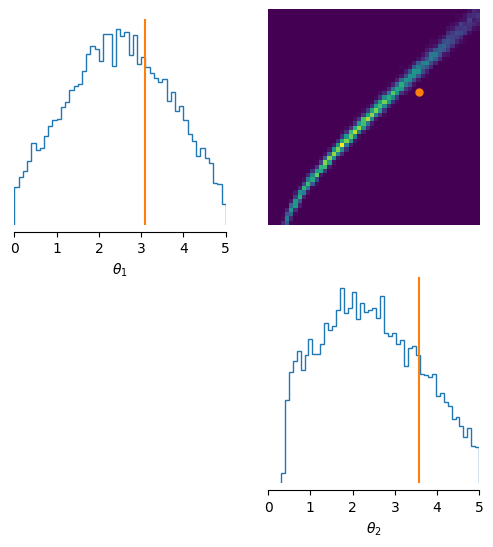

In [20]:
# Generate test data
n_test = 1
trace_test, params_test = GenerateDataForSBI(n_test, prior_limits, dt = dt, TotalT = TotalT)
autocorr_test = stat_corr_single(np.array(trace_test[0,:]),DeltaT = dt)
autocorr_test = autocorr_test[np.linspace(0, len(autocorr_test)-1, 500, dtype=np.int32)]
# Use test data to check if the posterior is working
samples = posterior_lin.sample((10000,), x=autocorr_test)
_ = analysis.pairplot(samples, points=params_test, limits=[[0.0, 5.], [0, 5.]], figsize=(6, 6), labels=[r"$\theta_1$", r"$\theta_2$"])

In [21]:
## Logarithmic Sampling of the Autocorrelation
# Setup SBI boilerplate
prior_box = utils.BoxUniform(low=torch.tensor([0.0, 0.0]), high=torch.tensor([5.0, 5.0]))
prior, num_parameters, prior_returns_numpy = process_prior(prior_box)
infer = SNPE(prior=prior)
# Train density estimator and extrace the posterior
inference_log = infer.append_simulations(params, log_autocorr_sample)
density_estimator_log = inference_log.train()
posterior_log = inference_log.build_posterior(density_estimator_log)

 Neural network successfully converged after 121 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

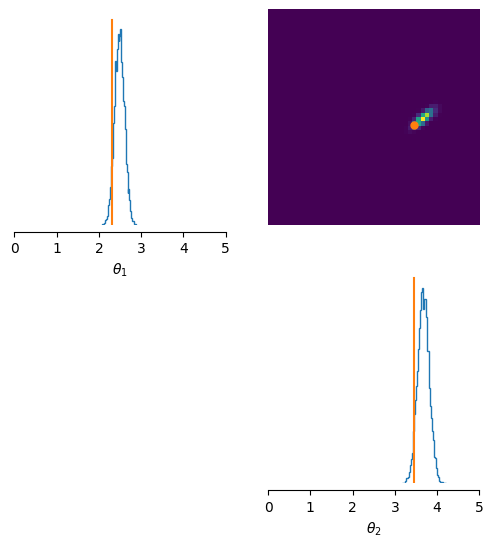

In [22]:
# Generate test data
n_test = 1
trace_test, params_test = GenerateDataForSBI(n_test, prior_limits, dt = dt, TotalT = TotalT)
autocorr_test = stat_corr_single(np.array(trace_test[0,:]),DeltaT = dt)

autocorr_test = autocorr_test[np.logspace(0, np.log10(len(autocorrelation)-1), 20, dtype=np.int32)]
# Use test data to check if the posterior is working
samples = posterior_log.sample((10000,), x=autocorr_test)
_ = analysis.pairplot(samples, points=params_test, limits=[[0.0, 5.], [0, 5.]], figsize=(6, 6), labels=[r"$\theta_1$", r"$\theta_2$"])